In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy

In [1]:
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# エラー補償手法について学ぶ

## 量子状態に対するエラー
まずは量子状態に対するエラーの理解を確認します。簡単な例として、$R_x(\theta)$ の回転ゲートを作用させたあと、確率 $p$ で $X$ ゲートがかかってしまうというモデル (ビット反転ノイズ) を考えます。以下は $\theta = [0,2\pi]$, $p=0.1, 0.2, 0.4$ について 1 が出る確率を計算して、結果をプロットするコードです。
([ラムゼー干渉](02_Ramsay.ipynb) のノイズありバージョンも参考。)

まずは $\theta, p$ を受けとって、そのときの 1 が出る確率 $P_1$ を出力する関数を用意します。

In [3]:
from qulacs.gate import RX, X
def get_one_prob(theta, p_noise, n_shots):
    one_prob = 0
    for _ in range(n_shots):
        state = QuantumState(1)
        RX(0, theta).update_quantum_state(state)
        if np.random.random() < p_noise:
            X(0).update_quantum_state(state)
        one_prob += state.sampling(1)[0]
    return one_prob/n_shots

上記関数を使って、結果をプロットします。

In [4]:
theta_list = np.linspace(0, 2*np.pi, 1000)
n_shots = 100
p_noise_list = [0, 0.1, 0.2, 0.4]
result_list = []
for p_noise in p_noise_list:
    res = np.array([get_one_prob(theta, p_noise, n_shots) for theta in theta_list])
    result_list.append(res)
## without statistical error
result_exact = np.sin(theta_list/2)**2

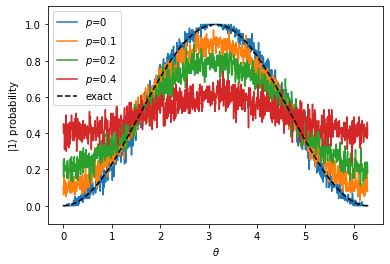

In [5]:
for p_noise, res in zip(p_noise_list, result_list):
    plt.plot(theta_list, res, label=f"$p$={p_noise}")
plt.plot(theta_list, result_exact, color="black", linestyle="dashed", label="exact")
plt.ylim(-0.1,1.1)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$|1\rangle$ probability")
plt.legend()
plt.show()

ノイズ強度が強くなるほどに、振幅が小さくなっていくことが確認できます。

## エラー補償法を試してみる。

### 外挿によるエラー補償

まずは外挿法によってエラー補償をしてみます。外挿法では、あるエラー $p$ におけるオブザーバブルの期待値 (ここでは $P_1$) が、 
$$P_1(p) = P_1(0) + \sum_{k=1}^{N} a_k p^N + O(p^{N+1})$$ 
のように書けることを仮定して、$P_1(0)$ を求めます。$p$ が十分小さいならば、最初の数項でうまい近似ができるはずです。

$p=0.1$, $p=0.2$ のデータを利用して、線形外挿 ($N=1$) によってエラー補償をしてみましょう。関数形を求めるのには、numpy に入っている [polyfit 関数](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)を使います。

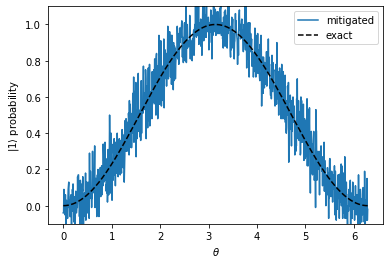

In [6]:
mitigated_1 = np.zeros_like(result_list[0])
for i in range(len(theta_list)):
    mitigated_1[i] = np.polyfit([0.1, 0.2], [result_list[1][i], result_list[2][i]], deg=1)[-1]
plt.plot(theta_list, mitigated_1, label="mitigated")
plt.plot(theta_list, result_exact, color="black", linestyle = "dashed", label="exact")
plt.ylim(-0.1,1.1)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$|1\rangle$ probability")
plt.legend()
plt.show()

かなりうまく補償できていることがわかります。

せっかくなので、$p=0.1, 0.2, 0.4$ を使って、$N=2$ で外挿するのもやってみましょう。

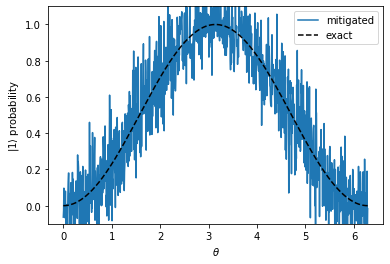

In [9]:
mitigated_2 = np.zeros_like(result_list[0])
for i in range(len(theta_list)):
    mitigated_2[i] = np.polyfit([0.1, 0.2, 0.4], [result_list[1][i], result_list[2][i], result_list[3][i]], deg=2)[-1]
plt.plot(theta_list, mitigated_2, label="mitigated")
plt.plot(theta_list, result_exact, color="black", linestyle = "dashed", label="exact")
plt.ylim(-0.1,1.1)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$|1\rangle$ probability")
plt.legend()
plt.show()

これもうまくできていますね。

### 確率的エラー消去法
次は確率的エラー消去法を使ってみます。ある確率 $p$ で $X$ エラーがかかっているとき、その直後に $X$ ゲートを意図的に作用させた結果も測定し、古典側で後処理をすることによってエラーを補償します。この場合、$X$ ゲートを作用させた場合の 1 の出現確率を $P_{1}'$ とすると、
$$P_1(0) = \frac{1}{(1-2p)}\left[(1-p)P_1 - pP_1'\right]$$ 
が成り立ちます。これを使ってエラー補償をしてみましょう。上記の式から、確率 $p$ で $X$ ゲートを意図的に作用させて測定を行い、$1$ が出たときは $-1$ を、確率 $1-p$ で何もせずに測定を行い、$1$ が出たときには $1$ を、それ以外の場合には $0$ を返すような変数 $x$ を使って、
$$P_1(0)=\frac{1}{(1-2p)} E[x]$$
が成り立ちます。このような操作を行う関数を以下に定義します。

In [10]:
def get_mitigated_one_prob(theta, p_noise, n_shots):
    one_prob = 0
    flag = 0 # flag for intentional X gate
    
    for _ in range(n_shots):
        
        state = QuantumState(1)
        RX(0, theta).update_quantum_state(state)
        
        # p_noise の確率でランダムなビット反転ノイズが作用する
        if np.random.random() < p_noise:
            X(0).update_quantum_state(state)
        
        # p_noise の確率で意図的に X ゲートを作用させる
        if np.random.random() < p_noise:
            X(0).update_quantum_state(state)
            flag = 1
        else:
            flag = 0
        # flag = 1 かつサンプルが 1 だったら -1 を足し込む
        # flag = 1 かつサンプルが 1 だったら 1 を足し込む
        # それ以外は何もしない。
        one_prob += (-1)**flag*state.sampling(1)[0]
    
    return one_prob/n_shots/(1-2*p_noise)

$p=0.1$ のノイズ確率について、補償された出力をシミュレートし、プロットしてみます。

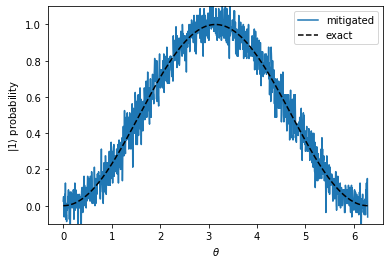

In [11]:
mitigated_3 = np.zeros_like(result_list[0])
p_noise = 0.1
for i, theta in enumerate(theta_list):
    mitigated_3[i] = get_mitigated_one_prob(theta, p_noise, n_shots)
plt.plot(theta_list, mitigated_3, label="mitigated")
plt.plot(theta_list, result_exact, color="black", linestyle = "dashed", label="exact")
plt.ylim(-0.1,1.1)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$|1\rangle$ probability")
plt.legend()
plt.show()

### 補償された出力の統計誤差

エラー補償を行うと、一般に統計誤差が大きくなります。上記3通りの統計誤差がどの程度になっているのか見てみましょう。ノイズなしかつ厳密な期待値からのズレをヒストグラム化してみます。

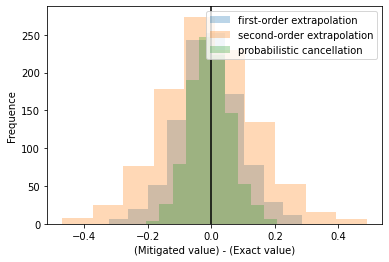

In [62]:
plt.hist(mitigated_1-result_exact, alpha=0.3, bins=10, label="first-order extrapolation")
plt.hist(mitigated_2-result_exact, alpha=0.3, bins=10, label="second-order extrapolation")
plt.hist(mitigated_3-result_exact, alpha=0.3, bins=10, label="probabilistic cancellation")
plt.axvline(0, color="black")
plt.ylabel("Frequence")
plt.xlabel("(Mitigated value) - (Exact value)")
plt.legend()
plt.show()

今回の場合、確率的エラー消去法が最も統計誤差を少なくエラー補償できていました。